In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import r2_score, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_blobs

from tensorflow.keras.datasets import mnist

In [2]:
def one_hot_encode(labels, num_classes=None):
    if num_classes is None:
        num_classes = np.max(labels) + 1

    one_hot_labels = np.zeros((labels.shape[0], num_classes))

    one_hot_labels[np.arange(labels.shape[0]), labels] = 1

    return one_hot_labels

# MLP from scratch

### Dense Layer

In [3]:
class Dense:
    def __init__(self, in_dim, out_dim, name=None):
        #self.W = np.random.randn(in_dim, out_dim)
        #self.b = np.random.randn(out_dim, 1)
        
        limit = np.sqrt(6 / (in_dim + out_dim))
        
        self.W = np.random.uniform(
            low = -limit,
            high = limit,
            size = (in_dim, out_dim)
        )
        self.b = np.zeros((out_dim, 1))
        
        self.X = None
        
        self.grad_W = None
        self.grad_b = None
        
        self.rW = None
        self.rb = None
        
        self.sW = None
        self.sb = None
        
        if name:
            self.Name = name
        else:
            self.Name = "Dense Layer"
    
        
    def get_name(self):
        return self.Name
        
    def forward(self, X):
        self.X = X
        return X @ self.W + np.ones((X.shape[0],1)) @ self.b.T
    
    def backward(self, upstream_grad):
        self.grad_W = self.X.T @ upstream_grad
        self.grad_b = np.sum(upstream_grad, axis=0, keepdims=True).reshape(self.b.shape)
        
        grad_X = upstream_grad @ self.W.T
        return grad_X

### Activation Functions

In [4]:
class ReLU:
    def __init__(self, name=None):
        self.X = None
        if name:
            self.Name = name
        else:
            self.Name = "ReLU"
        
    def get_name(self):
        return self.Name
        
    def forward(self, X):
        self.X = X
        return np.maximum(X, 0.0)
    
    def backward(self, upstream_gradient):
        return upstream_gradient * (self.X > 0)

In [5]:
class Sigmoid:
    def __init__(self, name=None):
        self.X = None
        if name:
            self.Name = name
        else:
            self.Name = "Sigmoid"
        
    def get_name(self):
        return self.Name
        
    @staticmethod
    def _sigmoid_func(Z):
        return 1 / (1 + np.exp(-Z))
    
    def forward(self, X):
        self.X = X
        return self._sigmoid_func(X)
    
    def backward(self, upstream_gradient):
        return upstream_gradient * self._sigmoid_func(self.X + 1e-8) * (1 - self._sigmoid_func(self.X) + 1e-8)

In [6]:
class SoftMax:
    def __init__(self, name=None):
        self.A = None
        if name:
            self.Name = name
        else:
            self.Name = "SoftMax"
        
    def get_name(self):
        return self.Name
        
    def forward(self, X):
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        A = exps / np.sum(exps, axis=1, keepdims=True)
        self.A = A
        return A
    
    def backward(self, upstream_gradient):
        # Use simple form of gradient when using cross-entropy loss
        return NotImplementedError

### Loss Functions

In [7]:
class MSELoss:
    def __init__(self, name=None):
        self.y = None
        self.y_hat = None
        if name:
            self.Name = name
        else:
            self.Name = "MSE Loss"
        
    def get_name(self):
        return self.Name
        
    def forward(self, y, y_hat):
        self.y = y
        self.y_hat = y_hat
        return 1/2 * np.mean((y - y_hat)**2)
    
    def backward(self):
        m = self.y.shape[0]
        return (self.y_hat - self.y)/m

In [8]:
class AbsoluteLoss:
    def __init__(self, name=None):
        self.y = None
        self.y_hat = None
        if name:
            self.Name = name
        else:
            self.Name = "Absolute Loss"
        
    def get_name(self):
        return self.Name
        
    def forward(self, y, y_hat):
        self.y = y
        self.y_hat = y_hat
        return np.mean(np.abs(y - y_hat))
    
    def backward(self):
        m = self.y.shape[0]
        return 1/m * np.sign(self.y_hat - self.y)

In [9]:
class BinaryCrossEntropy:
    def __init__(self, eps=1e-8, name=None):
        self.y = None
        self.y_hat = None
        self.eps = eps
        if name:
            self.Name = name
        else:
            self.Name = "Binary Cross-entropy Loss"
        
    def get_name(self):
        return self.Name
        
    def forward(self, y, y_hat):
        self.y = y
        self.y_hat = y_hat
        return -np.mean(y * np.log(y_hat + self.eps) + (1 - y) * np.log(1 - y_hat + self.eps))
    
    def backward(self):
        m = self.y.shape[0]
        num = self.y_hat - self.y
        den = self.y_hat * (1 - self.y_hat) + 1e-8
        return 1/m * num/den

In [10]:
class CategoricalCrossEntropy:
    def __init__(self, eps=1e-8, name=None):
        self.Y = None
        self.Y_hat = None
        self.eps = eps
        if name:
            self.Name = name
        else:
            self.Name = "Categorical Cross-entropy Loss"
        
    def get_name(self):
        return self.Name
        
    def forward(self, Y, Y_hat):
        self.Y = Y
        self.Y_hat = Y_hat
        return -np.mean(np.sum(Y * np.log(Y_hat + self.eps), axis=1))
    
    def backward(self):
        # Gradient of loss with respect to logits (Z)
        m = self.Y.shape[0]
        return (self.Y_hat - self.Y) / m

In [11]:
class MLP:
    def __init__(self):
        self.layers = []
        
    def add(self, layer):
        self.layers.append(layer)
    
    def _forward_pass(self, X, y):
        for i, layer in enumerate(self.layers):
            if i == 0:
                output = layer.forward(X)
            elif (i+1) == len(self.layers):
                loss = layer.forward(y, output)
            else:
                output = layer.forward(output)
        return loss
    
    def _backward_pass(self):
        multi_class = False
        if isinstance(self.layers[-1], CategoricalCrossEntropy):
            multi_class = True

        grad = self.layers[-1].backward()
        if multi_class:
            i = len(self.layers)-3
        else:
            i = len(self.layers)-2
        while i >= 0:
            grad = self.layers[i].backward(grad)
            i -= 1
            
    def fit(self, X, y, val_data=None, iterations=100, learning_rate=0.01, verbose=False):
        loss_hist = []
        for current_iter in range(iterations):
            loss = self._forward_pass(X, y)
            self._backward_pass()
            
            if val_data:
                val_loss = self._forward_pass(val_data[0], val_data[1])
            
            for layer in self.layers:
                if isinstance(layer, Dense):
                    layer.W -= learning_rate * layer.grad_W
                    layer.b -= learning_rate * layer.grad_b
                    
            if verbose:
                if val_data:
                    print(f"Iteration {current_iter+1}; Training loss: {loss:.3f}; Val loss: {val_loss:.3f}")
                else:
                    print(f"Iteration {current_iter+1}; Training loss: {loss:.3f}")
                    
            if val_data:
                loss_hist.append([loss, val_loss])
            else:
                loss_hist.append(loss)
                
    def predict(self, X):
        output = X
        for i, layer in enumerate(self.layers):
            if (i+1) != len(self.layers):
                output = layer.forward(output)
        return output

# Regression

In [12]:
def generate_spiral_regression(n=2000, noise=0.2, seed=4433):
    np.random.seed(seed)

    x = np.linspace(-3, 3, n)

    y = (
        x * np.sin(3*x)
        + 0.3 * x**2 * np.cos(2*x)
        + noise * np.random.randn(n)
    )

    # Standardize
    x = (x - x.mean()) / x.std()
    y = (y - y.mean()) / y.std()

    return x.reshape(-1, 1), y.reshape(-1, 1)

In [13]:
X, y = generate_spiral_regression(2000)

In [14]:
X = X.reshape(-1,1)
y = y.reshape(-1,1)

In [15]:
X.shape

(2000, 1)

In [16]:
y.shape

(2000, 1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### Model fitting

In [89]:
mlp = MLP()

mlp.add(Dense(X_train.shape[1],32))
mlp.add(ReLU())
mlp.add(Dense(32,16))
mlp.add(ReLU())
mlp.add(Dense(16,1))
mlp.add(MSELoss())

In [90]:
mlp.fit(X_train, y_train, val_data=[X_val, y_val], iterations=1000, learning_rate=0.1, verbose=False)

In [91]:
y_pred = mlp.predict(X_test)

In [92]:
print(mean_squared_error(y_test, y_pred))

0.051143109358388436


In [93]:
print(r2_score(y_test, y_pred))

0.9523061917554212


In [94]:
xseq = np.linspace(X.min()-1e-02,X.max()+1e-02,100)
yseq = mlp.predict(xseq.reshape(-1,1))

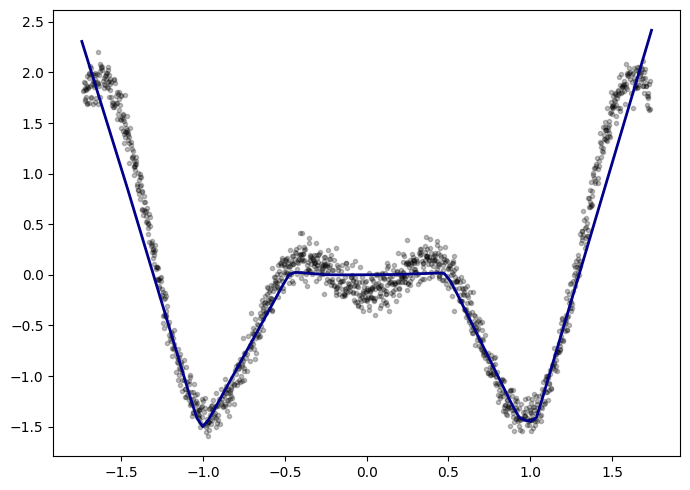

In [95]:
plt.figure(figsize=(7,5))
plt.scatter(X_train, y_train, c='black', alpha=0.25, marker='.')
plt.plot(xseq, yseq.ravel(), color='darkblue', linewidth=2.0)
plt.tight_layout()
plt.show()

# Binary Classification

In [96]:
def generate_spiral_classification(n_per_class=1000, noise=0.2, seed=4433):
    np.random.seed(seed)

    n = 2 * n_per_class
    X = np.zeros((n, 2))
    y = np.zeros(n, dtype=int)

    for j in range(2):
        ix = range(n_per_class*j, n_per_class*(j+1))
        r = np.linspace(0.0, 1, n_per_class)
        t = np.linspace(j*np.pi, (j+2)*np.pi, n_per_class) + noise*np.random.randn(n_per_class)

        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    return X, y

In [97]:
#X, y = generate_multiclass_data(1000, 2, cluster_std=3.5)
X, y = generate_spiral_classification(noise=0.5)
y = y.reshape(-1,1)

In [98]:
N, p = X.shape

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

### Model fitting

In [124]:
mlp = MLP()

mlp.add(Dense(X_train.shape[1], 256))
mlp.add(ReLU())
mlp.add(Dense(256, 128))
mlp.add(ReLU())
mlp.add(Dense(128, y_train.shape[1]))
mlp.add(Sigmoid())
mlp.add(BinaryCrossEntropy())

In [125]:
mlp.fit(X_train, y_train, val_data=[X_val, y_val], iterations=5000, learning_rate=0.1, verbose=False)

In [126]:
y_pred_prob = mlp.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

In [127]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       199
           1       1.00      0.99      0.99       201

    accuracy                           0.99       400
   macro avg       1.00      1.00      0.99       400
weighted avg       1.00      0.99      0.99       400



In [128]:
def plot_2D_binary_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 0.1, X[:,0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    
    xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_prob = model.predict(x_in)
    y_pred = np.array([1 if u>=0.5 else 0 for u in y_prob]).reshape(xx.shape)
    
    plt.figure(dpi=300, figsize=(7,5))
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:,0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.tight_layout()

    plt.show()

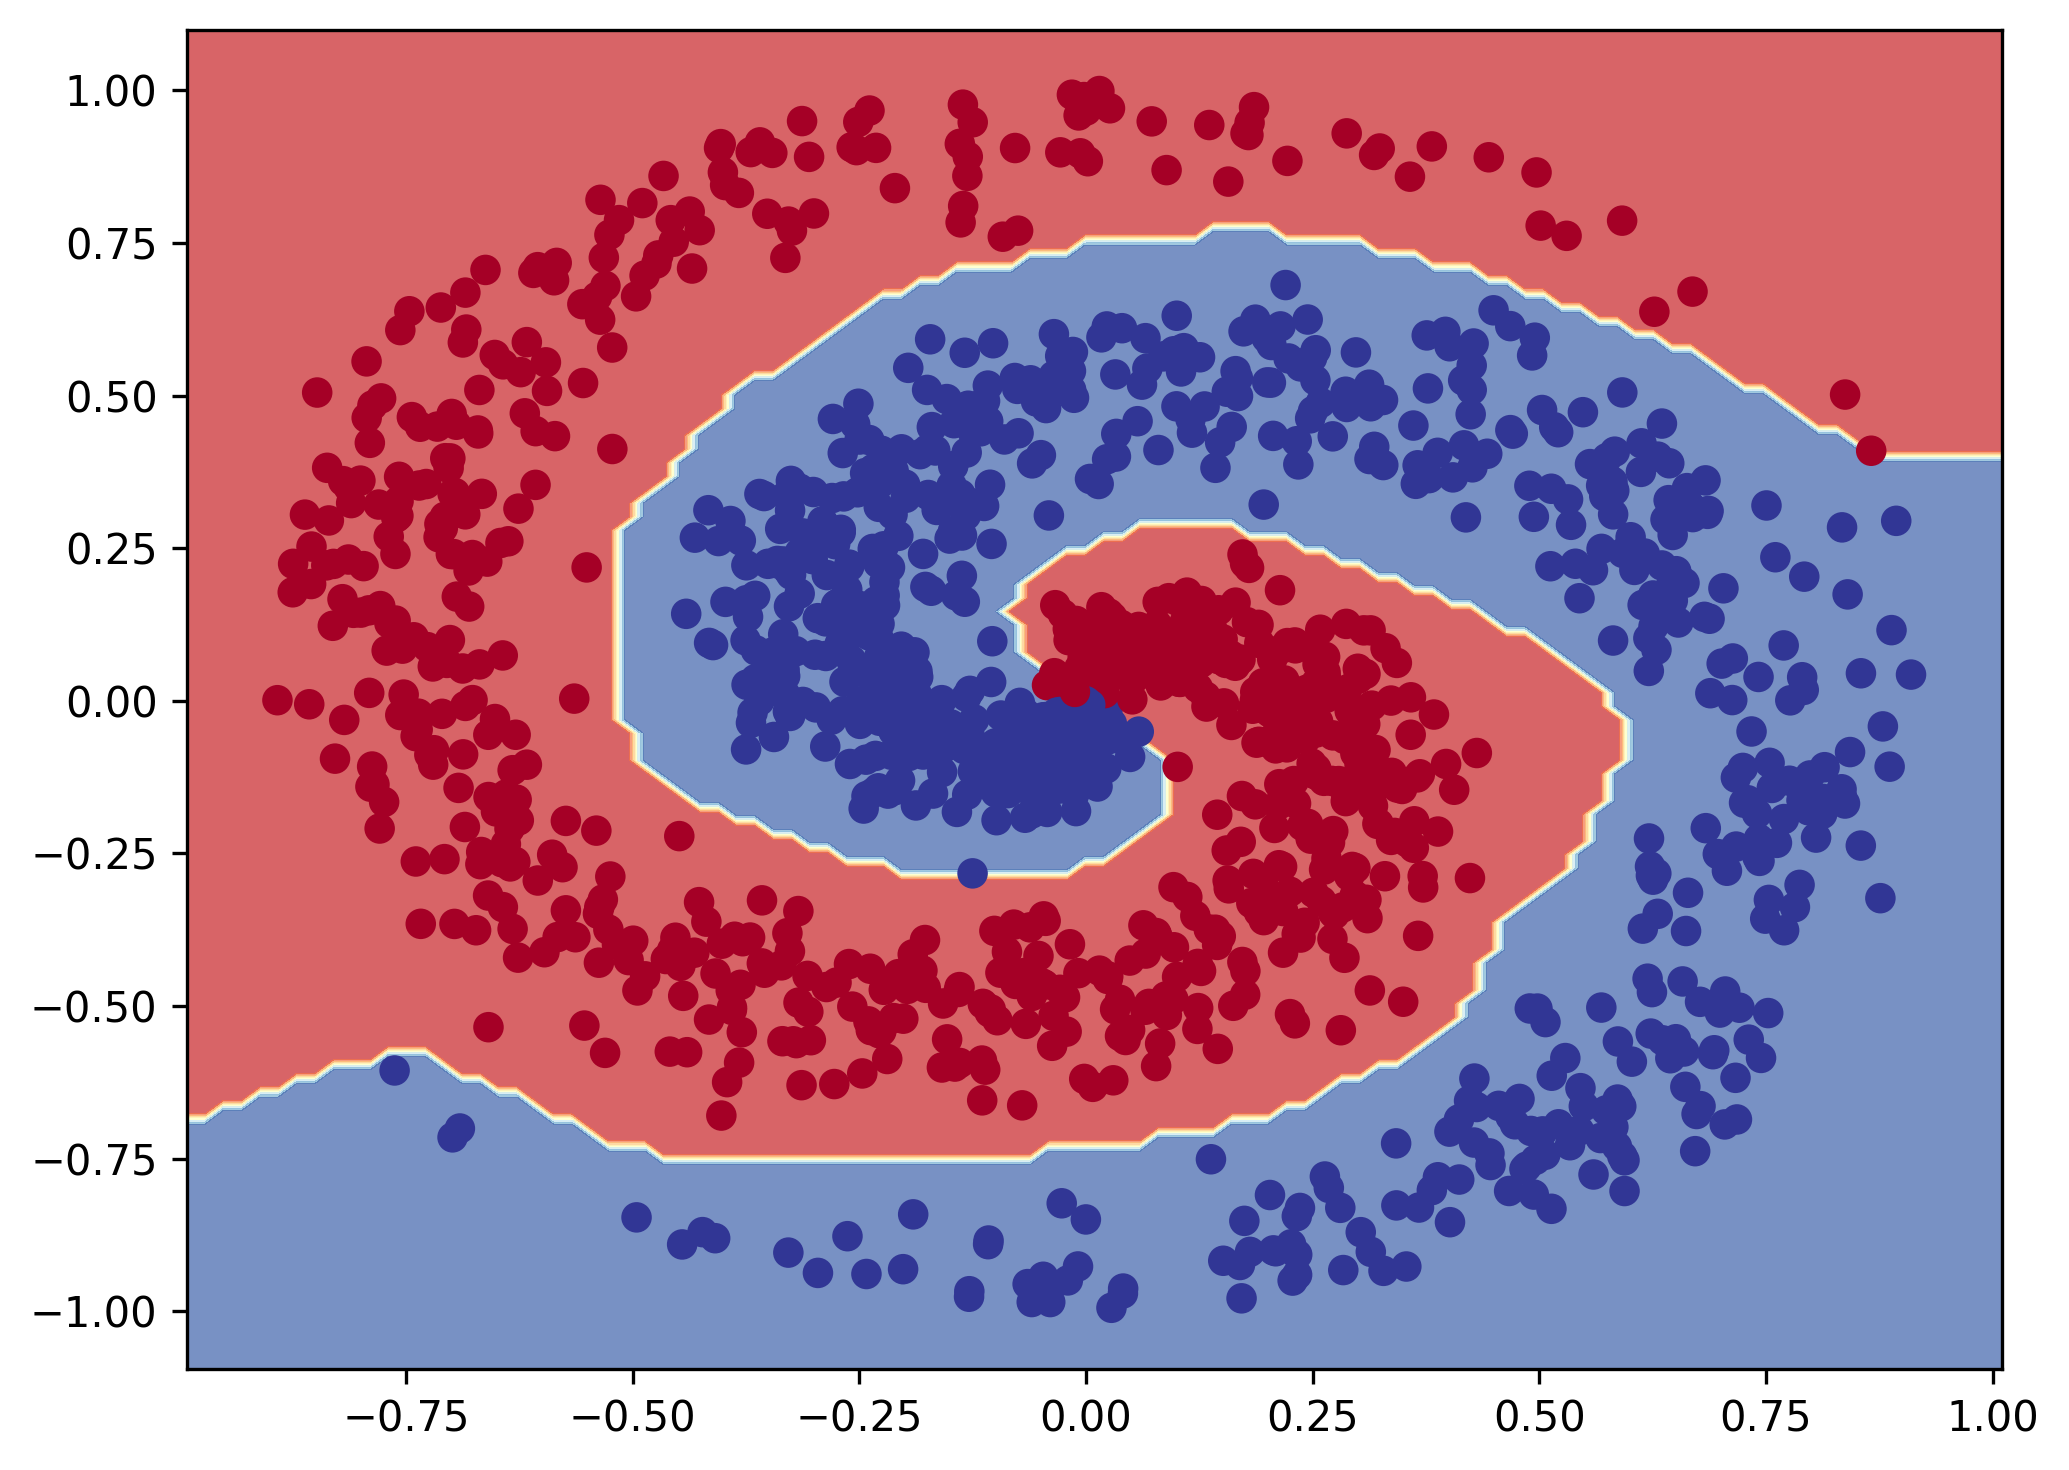

In [129]:
plot_2D_binary_decision_boundary(X_train, y_train, mlp)

# Multi-class Classification

In [130]:
def generate_multiclass_data(n, n_classes, seed=9090, cluster_std=3.5):
    np.random.seed(seed)
    X, y = make_blobs(n_samples=n, centers=n_classes, n_features=2, cluster_std=cluster_std)
    return X,y

In [131]:
n_classes = 3

X, y = generate_multiclass_data(1000, n_classes)

In [132]:
N, p = X.shape

In [133]:
Y = one_hot_encode(y, n_classes)

In [134]:
Y

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], shape=(1000, 3))

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Model fitting

In [136]:
mlp = MLP()

mlp.add(Dense(X_train.shape[1], 512))
mlp.add(ReLU())
mlp.add(Dense(512, 64))
mlp.add(ReLU())
mlp.add(Dense(64, y_train.shape[1]))
mlp.add(SoftMax())
mlp.add(CategoricalCrossEntropy())

In [137]:
mlp.fit(X_train, y_train, iterations=1000, learning_rate=0.1, verbose=False)

In [138]:
y_pred_prob = mlp.predict(X_test)
y_pred = one_hot_encode(np.argmax(y_pred_prob, axis=1))

In [139]:
y_pred

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1

In [140]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        62
           1       0.99      0.99      0.99        76
           2       1.00      0.98      0.99        62

   micro avg       0.99      0.99      0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200
 samples avg       0.99      0.99      0.99       200



In [141]:
def plot_2D_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 0.1, X[:,0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    
    xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_prob = model.predict(x_in)
    y_pred = y_prob.argmax(axis=1).reshape(xx.shape)
    
    plt.figure(dpi=300, figsize=(7,5))
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:,0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.tight_layout()
    plt.show()

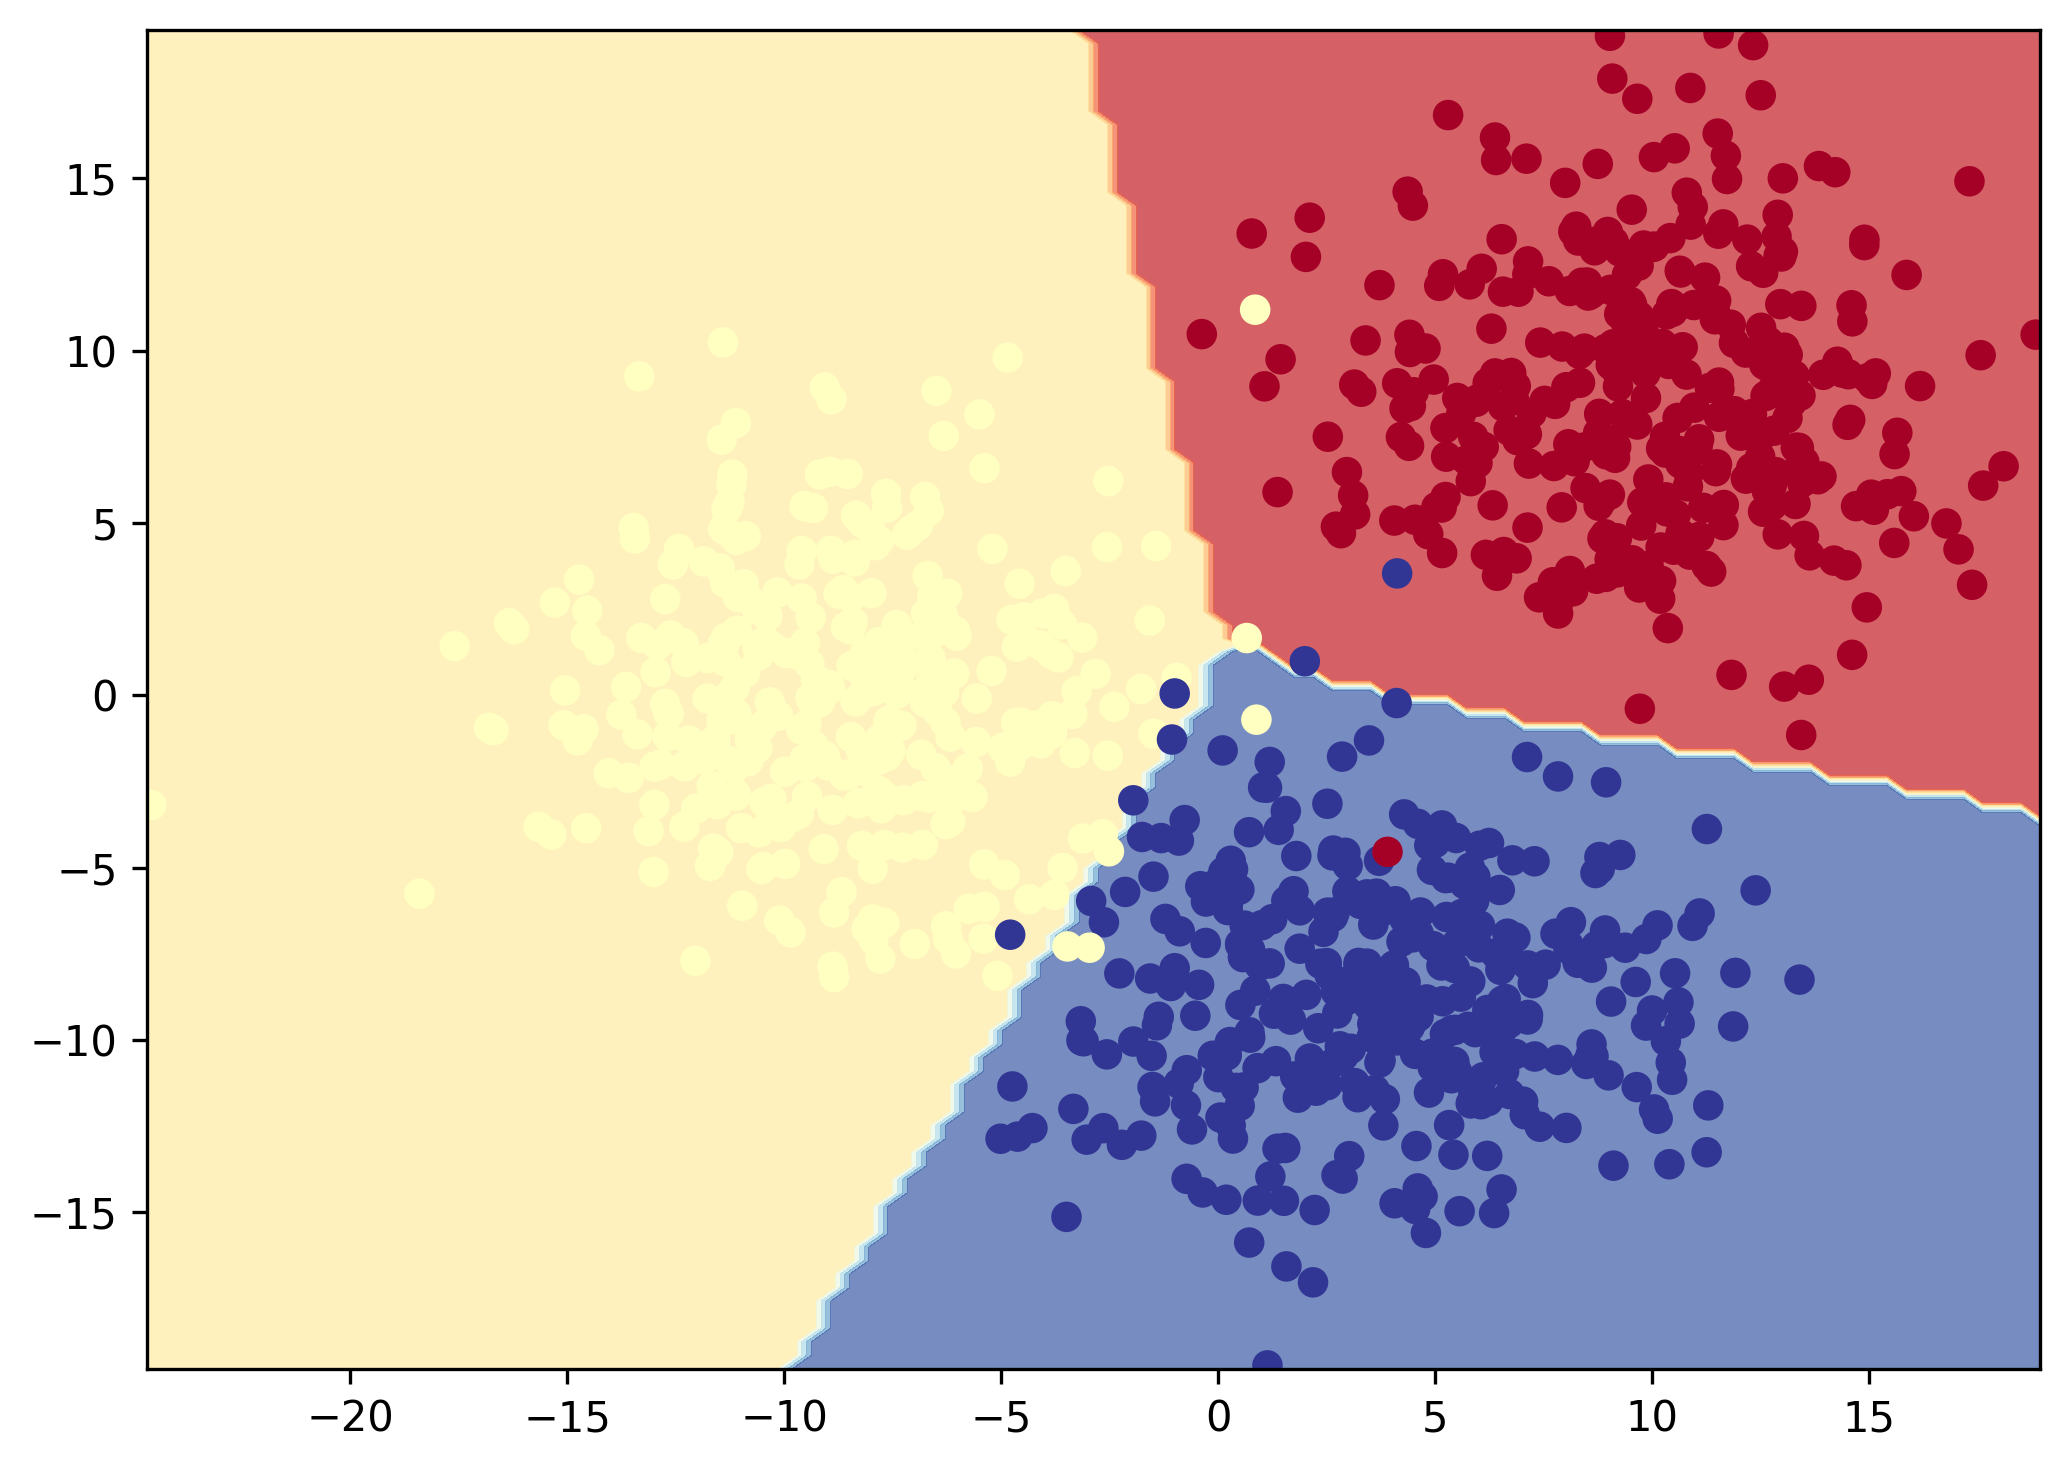

In [142]:
plot_2D_decision_boundary(X, y, mlp)

## MNIST data

In [143]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [144]:
np.random.seed(1)
sample = np.random.choice(range(X_train.shape[0]), size=5000, replace=False)

X, y = X_train[sample], y_train[sample]

In [145]:
y_cat = one_hot_encode(y)

In [146]:
y_cat.shape

(5000, 10)

In [147]:
X = X.reshape(-1,28*28)

In [148]:
X.shape

(5000, 784)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3, random_state=42)

In [150]:
model = MLP()

model.add(Dense(X.shape[1], 1024))
model.add(ReLU())
model.add(Dense(1024, y_train.shape[1]))
model.add(SoftMax())
model.add(CategoricalCrossEntropy())

In [151]:
model.fit(X_train, y_train, iterations=100, learning_rate=0.001, verbose=False)

In [152]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

In [153]:
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       131
           1       0.98      0.94      0.96       178
           2       0.90      0.87      0.89       149
           3       0.86      0.82      0.84       169
           4       0.87      0.90      0.89       167
           5       0.76      0.83      0.80       115
           6       0.95      0.93      0.94       168
           7       0.88      0.86      0.87       158
           8       0.75      0.78      0.76       123
           9       0.80      0.82      0.81       142

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500

